In this notebook we'll split the Biogen solubility dataset into training and test sets.  We'll then use the training and test sets to build machine learning models. 

In [2]:
import pandas as pd
import datamol as dm
from molfeat.trans import MoleculeTransformer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
import datamol as dm
from helper import scaffold_split
from tqdm.auto import tqdm
import seaborn as sns

Read the data

In [3]:
df = pd.read_csv("biogen_solubility.csv")
len(df)

2173

Instantiate a transformer object to generate RDKit 2D descriptors

In [4]:
transformer = MoleculeTransformer(featurizer='desc2D',dype=float)

Generate the descriptors

In [5]:
with dm.without_rdkit_log():
    desc2D = transformer(df.SMILES.values)

Add the descriptors to the dataframe

In [6]:
df['desc2D'] = list(desc2D)

Perform 10 folds of cross validation with random splits

In [7]:
random_split_res_list = []
for i in tqdm(range(0,10)):
    lgbm = LGBMRegressor()
    train, test = train_test_split(df,random_state=i)
    lgbm.fit(np.stack(train.desc2D),train.logS)
    pred = lgbm.predict(np.stack(test.desc2D))    
    r = pearsonr(test.logS, pred).statistic
    mae = mean_absolute_error(test.logS, pred)
    random_split_res_list.append([r, mae])
random_split_df = pd.DataFrame(random_split_res_list,columns=["r","mae"])
random_split_df['method'] = 'random'

  0%|          | 0/10 [00:00<?, ?it/s]

Perform 10 folds of cross validation with scaffold splits

In [8]:
scaffold_split_res_list = []
for i in tqdm(range(0,10)):
    lgbm = LGBMRegressor()
    train_idx, test_idx = scaffold_split(df.SMILES,seed=i)
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    lgbm.fit(np.stack(train.desc2D),train.logS)
    pred = lgbm.predict(np.stack(test.desc2D))    
    r = pearsonr(test.logS, pred).statistic
    mae = mean_absolute_error(test.logS, pred)
    scaffold_split_res_list.append([r, mae])
scaffold_split_df = pd.DataFrame(scaffold_split_res_list, columns=["r","mae"])
scaffold_split_df['method'] = 'scaffold'

  0%|          | 0/10 [00:00<?, ?it/s]

Combine the results from the ML models into one dataframe

In [9]:
combo_df = pd.concat([random_split_df, scaffold_split_df])

Plot the comparison

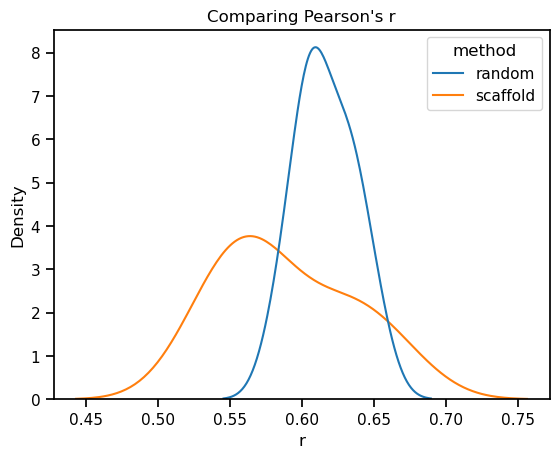

In [13]:
sns.set_context('notebook')
ax = sns.kdeplot(x="r",hue='method',data=combo_df)
ax.set_title("Comparing Pearson's r");

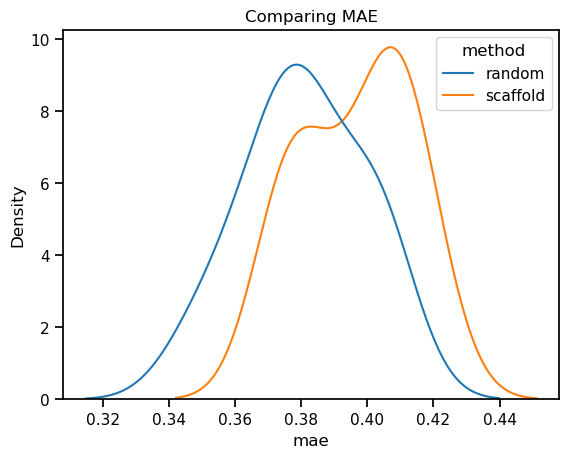

In [12]:
sns.set_context('notebook')
ax = sns.kdeplot(x="mae",hue='method',data=combo_df)
ax.set_title("Comparing MAE");